100%|██████████████████████████████████████████████████████████████████████████████| 1829/1829 [00:27<00:00, 65.93it/s]


Best Isolation Forest Model
F1-score: 0.8292682926829268
              precision    recall  f1-score    support
0              0.999189  0.996562  0.997874  4945.0000
1              0.750000  0.927273  0.829268    55.0000
accuracy       0.995800  0.995800  0.995800     0.9958
macro avg      0.874594  0.961917  0.913571  5000.0000
weighted avg   0.996448  0.995800  0.996019  5000.0000


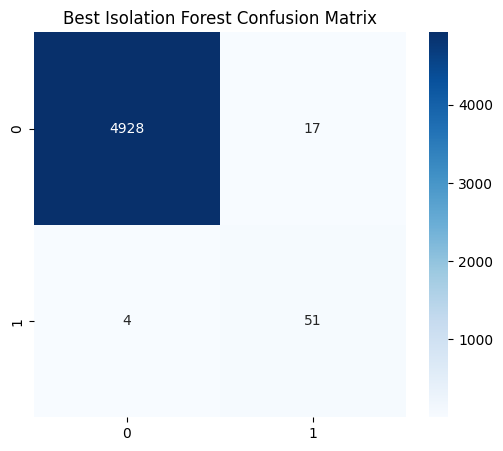

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Paths and settings
BASE_DIR = "X:/DataSet/Data"
AGG_LEVELS = ["agg_1_hour"]  # using 1-hour aggregation
FOLDERS = ["institutions", "institution_subnets", "ip_addresses_full", "ip_addresses_sample"]
SELECTED_FEATURES = [
    "n_flows", "n_packets", "n_bytes", "avg_duration",
    "tcp_udp_ratio_packets", "tcp_udp_ratio_bytes",
    "dir_ratio_packets", "dir_ratio_bytes",
    "avg_ttl", "sum_n_dest_ports", "average_n_dest_ports", "std_n_dest_ports",
    "sum_n_dest_ip", "average_n_dest_ip", "std_n_dest_ip",
    "sum_n_dest_asn", "average_n_dest_asn", "std_n_dest_asn"
]

# Load up to 50,000 CSVs
all_files = []
for folder in FOLDERS:
    for agg in AGG_LEVELS:
        dir_path = os.path.join(BASE_DIR, folder, agg)
        if os.path.exists(dir_path):
            all_files += [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".csv")]

subset_files = all_files[:50000]
df_list = []
for f in tqdm(subset_files):
    try:
        df = pd.read_csv(f)
        common_features = [feat for feat in SELECTED_FEATURES if feat in df.columns]
        if common_features:
            df_list.append(df[common_features])
    except:
        continue

if not df_list:
    raise ValueError("No valid files loaded. Please check selected features and file contents.")

full_df = pd.concat(df_list, ignore_index=True).dropna()

# Feature engineering
full_df['packets_per_flow'] = full_df['n_packets'] / (full_df['n_flows'] + 1)
full_df['bytes_per_packet'] = full_df['n_bytes'] / (full_df['n_packets'] + 1)
full_df['flows_to_ports_ratio'] = full_df['n_flows'] / (full_df.get('sum_n_dest_ports', 1) + 1)

# Label anomalies: top 1% n_flows
full_df['anomaly'] = (full_df['n_flows'] > full_df['n_flows'].quantile(0.99)).astype(int)

X = full_df.drop(columns=['anomaly'])
y = full_df['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, train_size=45000, random_state=42)

# Isolation Forest tuning
best_score = 0
best_model = None
best_report = None
best_cm = None

for contamination in [0.01, 0.015, 0.02, 0.03]:
    model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42, n_jobs=-1)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']
    if f1 > best_score:
        best_score = f1
        best_model = model
        best_report = report
        best_cm = confusion_matrix(y_test, y_pred)

# Results
print("Best Isolation Forest Model")
print("F1-score:", best_score)
print(pd.DataFrame(best_report).transpose())

plt.figure(figsize=(6, 5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Best Isolation Forest Confusion Matrix")
plt.show()
